# An Optimal Control Approach of Robot Manipulator
## Implementation

In [6]:
from sympy import symbols, Symbol, Matrix, Pow, cos, sin
import sympy
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

### Defining and Assigning Variables:
These Variables are the physical characterstics of Scara Manipulator, such as mass, intertia, friction etc.

In [7]:
# state variable
q1, q2, q1_dot, q2_dot = symbols("q1 q2 q1_dot q2_dot")
state = Matrix([[q1],[q2],[q1_dot],[q2_dot]])

# variables
m1, m2 = symbols("m1 m2") # oz
J1, J2 = symbols("J1 J2") # oz-in/rad/sec^2
r1, r2 = symbols("r1 r2") # in
l1, l2 = symbols("l1 l2") # in
b1, b2 = symbols("b1 b2") # oz-in/rad/sec

variables = {m1:13.86,m2:3.33,J1: 62.39,J2:16.7, r1:6.12, r2:3.22, l1:8, l2:6, b1:0.2,b2:0.5}
# load 
e = Symbol("e") # e belongs to [0,1]
ml = 10*e  # Symbol("ml") # oz
Jl = 60*Pow(e,2) #Symbol("Jl") # oz-in/rad/sec^2
load_variables = {e:1}

### Defining Inertia Matrix (M)

In [8]:
# inertia Matrix
M11 = J1+m1*Pow(r1,2)+J2+m2*(Pow(l1,2)+Pow(r2,2)+2*l1*r2*cos(q2))+Jl+ml*(Pow(l1,2)+Pow(l2,2)+2*l1*l2*cos(q2))
M12 = J2 + m2*(Pow(r2,2)+l1*r2*cos(q2))+Jl+ml*Pow(l2,2)
M21 = M12
M22 = J2+m2*Pow(r2,2)+Jl+ml*Pow(l2,2)
M = Matrix([[M11,M12],[M21,M22]])
# M = Matrix([M11,M12])
M0 = M.subs({**variables,**load_variables})
M0

Matrix([
[1131.5616*cos(q2) + 1905.854756, 85.7808*cos(q2) + 471.226772],
[   85.7808*cos(q2) + 471.226772,                   471.226772]])

### Defining Matrix (N)
This Matrix contains information of frictional force and centripital force. The gravitational force $g(x) = 0$


In [9]:
# N (friction+centripital force)
n1 = (m2*l1*r2+ml*l1*l2)*(Pow(q2_dot,2)+2*q1_dot*q2_dot)*sin(q2)+b1*q1_dot
n2 = (m2*l1*r2+ml*l1*l2)*Pow(q1_dot,2)*sin(q2)+b2*q2_dot
N = Matrix([[n1],[n2]])
# N
N0 = N.subs({**variables,**load_variables})
N0

Matrix([
[0.2*q1_dot + 565.7808*(2*q1_dot*q2_dot + q2_dot**2)*sin(q2)],
[                    565.7808*q1_dot**2*sin(q2) + 0.5*q2_dot]])

### Optimal Control input (u0)
The u0 is been calculated using LQR controller after solving the cost function, for optimal control problem:
$$
\int_0^\infty (x^TPx+x^Tx+u^Tu)dt
$$

In [10]:
# optimal control input
X1 = Matrix([[q1],[q2]])
K = Matrix([[14.803,1.3591],[1.3591,2.8553]])
X2 = Matrix([[q1_dot],[q2_dot]])
u0 = -X1-K*X2

### Defining uncertainties:
Defining the system dynamic uncertainty $f(x)$, and input uncertainty $h(x)$.
where,
$$
h(x) = M^{-1}M-I
$$
$$
f(x) = M^{-1}(N_0-N)
$$

In [11]:
def get_uncertainties(M_sub, N_sub, N0):
    # Matched uncertainty in system dynamics, 
    f = M_sub.inv()*(N0-N_sub)

    # uncertainty input matrix, 
    h = M_sub.inv()*M_sub-sympy.eye(2)

    return f,h

### Defining State Space equation
$$
\dot x  = Ax+B(u+h(x)u)+Bf(x)
$$
Calculating next state, for given $\delta t$ (dt) time interval.

In [12]:
def state_space_model(A,B,state,optimal_input,h,f,dt):
    state_dot = A*state+B*(optimal_input+h*optimal_input)+B*f
    # sympy.pprint(state_dot)
    q1 = state[0]+state_dot[0]*dt
    q2 = state[1]+state_dot[1]*dt
    q1_dot = state[2]+state_dot[2]*dt
    q2_dot = state[3]+state_dot[3]*dt
    next_state = Matrix([q1,q2,q1_dot,q2_dot]).reshape(4,1)
    return next_state


### Looping to stabilise the system.

* total_time = 100
* dt = .1 ($\delta t$)

* e = 0 ($\epsilon = 0$ can have value in $ [0,0.5,1]$) 
* $A$ matrix of state space dynamic equation
$$
A = \begin{bmatrix} 
        0 & 0 &1 & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & 0 & 0 \\
        0& 0 & 0 & 0
    \end{bmatrix}
$$
* $B$ matrix of state space dynamic equation
$$
B = \begin{bmatrix}
        0 & 0 \\
        0 & 0 \\
        1 & 0 \\
        0 & 1
    \end{bmatrix}
$$

In [13]:
total_time = 100
dt = .1
# e = 0
load_variables = {e:0}
A = Matrix([[0,0,1,0],[0,0,0,1],[0,0,0,0],[0,0,0,0]])
B = Matrix([[0,0],[0,0],[1,0],[0,1]])
q1s = []
q2s = []
q1_dots = []
q2_dots = []
u1s = []
u2s = []
Ts = np.arange(0,total_time,dt)

X_states = {q1:math.radians(60),q2:math.radians(-30),q1_dot:0,q2_dot:0}
curr_state = state.subs(X_states)
for i in tqdm(Ts):
    X_states = {q1:curr_state[0],q2:curr_state[1],q1_dot:curr_state[2],q2_dot:curr_state[3]}
    # print("\ncurrent_states: ",X_states)
    optimal_control_input = u0.subs(X_states)
    M_sub = M.subs({**variables, **load_variables,**X_states})
    N_sub = N.subs({**variables, **load_variables,**X_states})
    N0_sub = N0.subs(X_states)

    f,h = get_uncertainties(M_sub,N_sub,N0_sub)
    
    u1s.append(optimal_control_input[0])
    u2s.append(optimal_control_input[1])
    q1s.append(X_states[q1])
    q2s.append(X_states[q2])
    q1_dots.append(X_states[q1_dot])
    q2_dots.append(X_states[q2_dot])

    next_state = state_space_model(A,B,curr_state,optimal_control_input,h,f,dt)
    curr_state=next_state

100%|██████████| 1000/1000 [00:46<00:00, 21.28it/s]


### Plotting 
* Plotting the states : $q_1$,$q_2$,$\dot q_1$, $\dot q_2$
* Plotting the element of optimal control input matrix (u0): $ u_0 $ and $u_1$

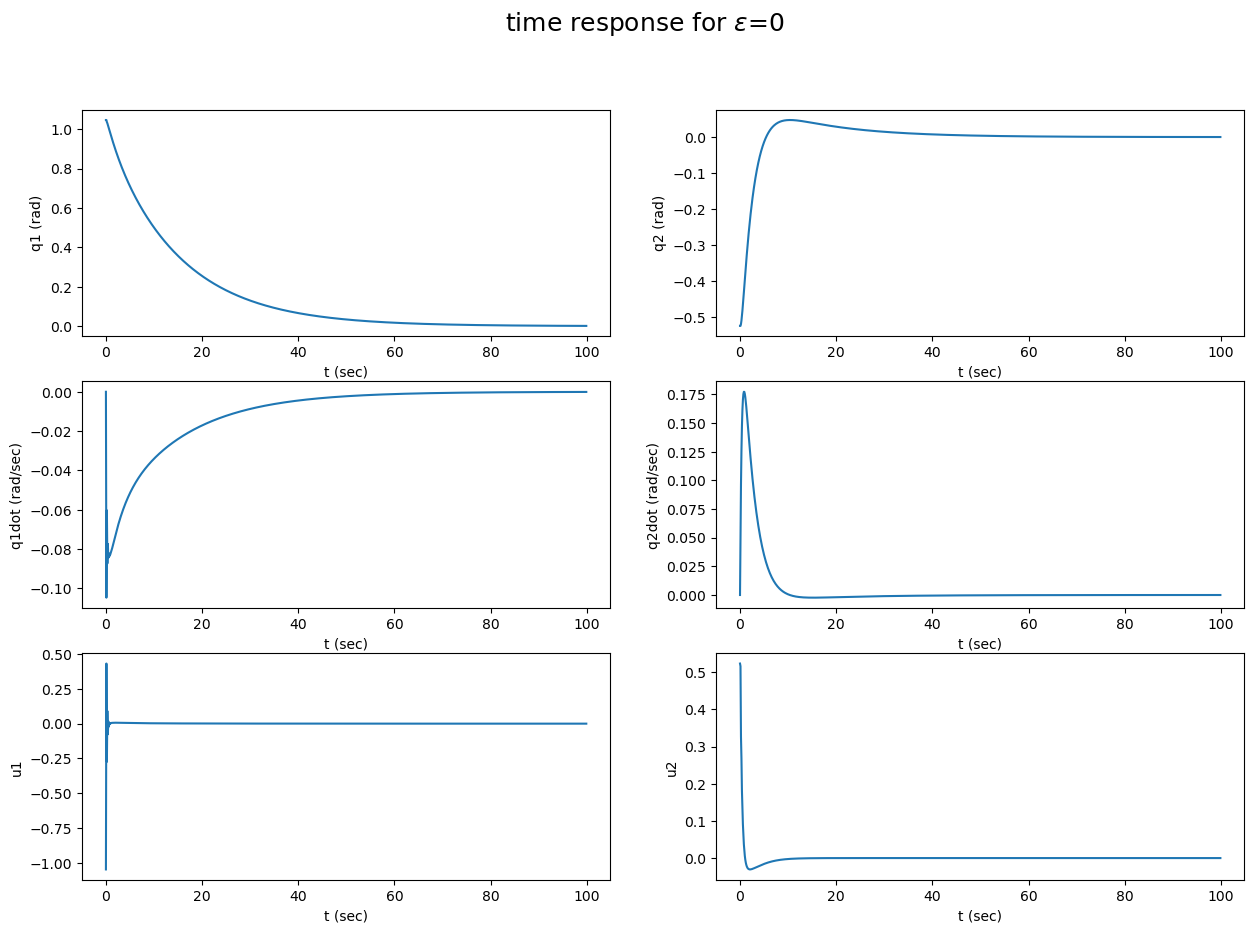

In [17]:
# plotting
fig,axs = plt.subplots(nrows=3,ncols=2,figsize=(15,10))
fig.suptitle(r"time response for $\epsilon$=0",fontsize=18)
# print(axs)
ax1 = axs[0,0]
ax1.set_xlabel("t (sec)")
ax1.set_ylabel("q1 (rad)")
ax1.plot(Ts,q1s)

ax2 = axs[0,1]
# ax2 =  plt.subplot(322,autoscale_on=True)
ax2.set_xlabel("t (sec)")
ax2.set_ylabel("q2 (rad)")
ax2.plot(Ts,q2s)

ax3 = axs[1,0]
# ax3 =  plt.subplot(323)
ax3.set_xlabel("t (sec)")
ax3.set_ylabel("q1dot (rad/sec)")
ax3.plot(Ts,q1_dots)

ax4 = axs[1,1]
# ax4 =  plt.subplot(324)
ax4.set_xlabel("t (sec)")
ax4.set_ylabel("q2dot (rad/sec)")
ax4.plot(Ts,q2_dots)

ax5 = axs[2,0]
# ax5 =  plt.subplot(325)
ax5.set_xlabel("t (sec)")
ax5.set_ylabel("u1")
ax5.plot(Ts,u1s)

ax6 = axs[2,1]
# ax6 =  plt.subplot(326)
ax6.set_xlabel("t (sec)")
ax6.set_ylabel("u2")
ax6.plot(Ts,u2s)

plt.show()